# One-class SVM, SVDD, PCA-based Reconstruction 코드 실습

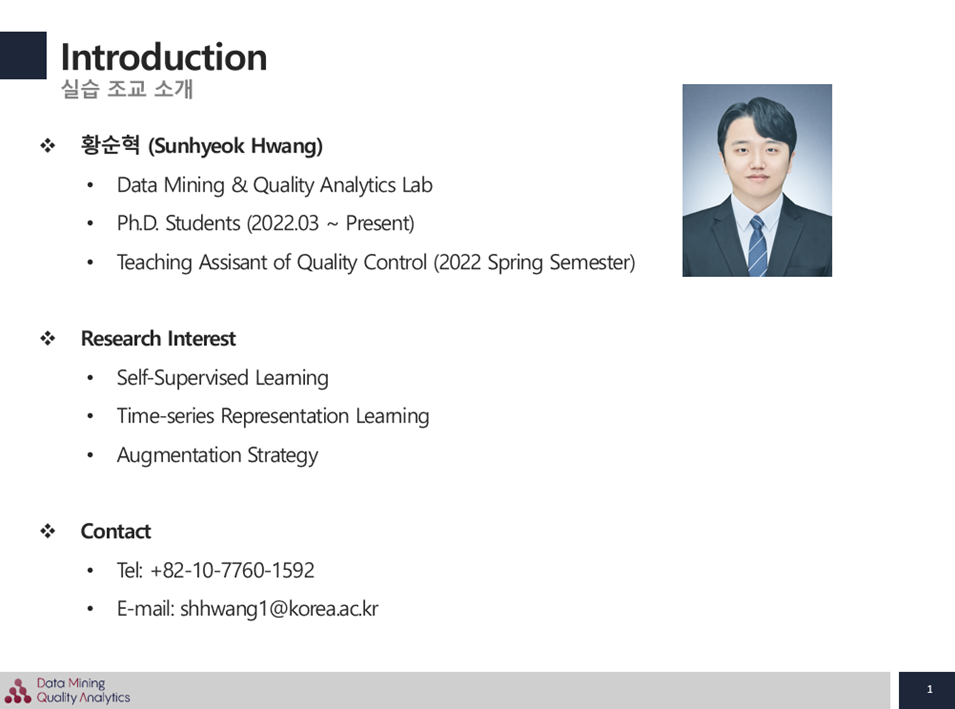

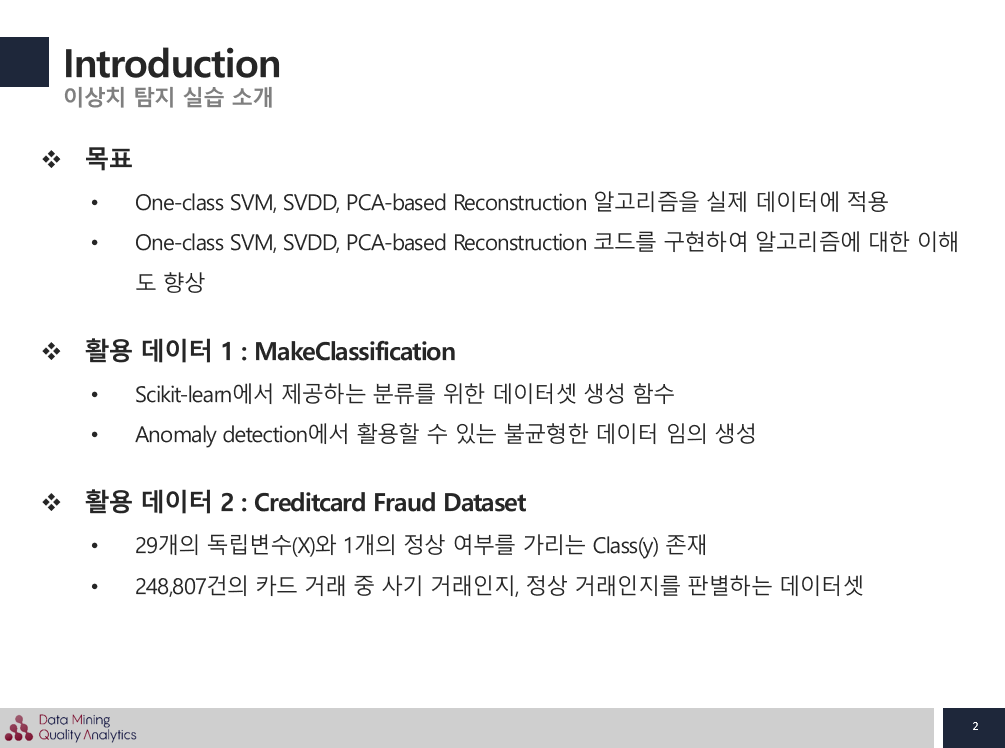

### 1. 모듈 불러오기

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

### 2. 데이터 불러오기

#### 2-1. MakeClassification Data

In [3]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.98, 0.02],
                           class_sep=0.5, random_state=2022)
# Convert the data from numpy array to a pandas dataframe
MC_df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})
# Check the target distribution

MC_df

feature1  feature2  target
0    -0.288017 -0.319407       0
1     0.461567  0.222732       0
2     1.947707 -0.952528       0
3     0.702101 -0.971503       0
4     0.291875 -0.837983       0
...        ...       ...     ...
9995  0.649173 -1.040183       0
9996 -0.485421  0.232143       0
9997  2.315266 -1.152743       0
9998  1.469482  0.211030       0
9999 -0.060250 -0.100417       0

[10000 rows x 3 columns]

In [4]:
MC_df = MC_df.sort_values(by='target')
MC_df = MC_df.reset_index(drop=True)

In [5]:
MC_df

feature1  feature2  target
0    -0.288017 -0.319407       0
1    -1.407831 -0.331263       0
2     0.588010 -0.392650       0
3    -1.079708 -0.242353       0
4    -0.220421 -0.433775       0
...        ...       ...     ...
9995  0.617079  2.184648       1
9996 -1.072066  0.308414       1
9997  1.355220 -1.135850       1
9998  1.035234 -2.984830       1
9999  0.698291  1.348734       1

[10000 rows x 3 columns]

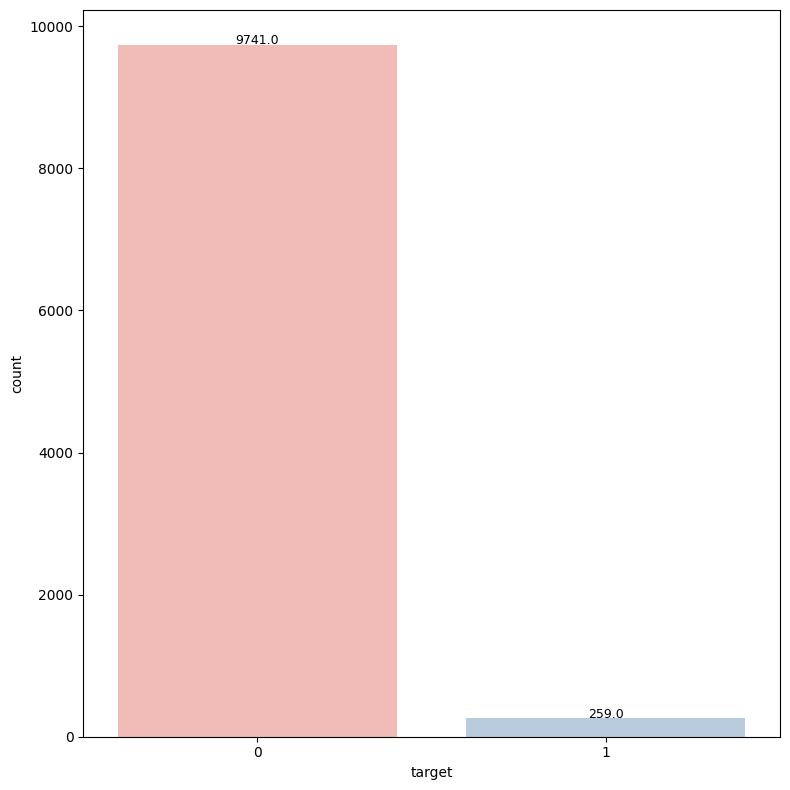

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
plt.rcParams['axes.facecolor'] = 'white'
ax = sns.countplot(x='target', data=MC_df, palette='Pastel1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.tight_layout()

In [7]:
X = MC_df.iloc[:, :-1]
y = MC_df.iloc[:, -1]

X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]))
print(len(y_test[y_test == 0]))

(8000, 2)
(2000, 2)
(8000,)
(2000,)
0
8000
259
1741


In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def return_result(y_true, y_pred):
    performance = {}
    performance['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    performance['precision_score'] = precision_score(y_true=y_true,y_pred=y_pred)
    performance['recall_score'] = recall_score(y_true=y_true,y_pred=y_pred)
    performance['f1_score'] = f1_score(y_true=y_true,y_pred=y_pred)
    
    return performance

def cf_vis(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cf, annot=True, fmt='d', cmap='Pastel1')
    
    return cf

#### 2-2. CreditCard Data

In [9]:
import pandas as pd

card_df = pd.read_csv('./creditcard.csv')

card_df = card_df.drop('Time', axis=1)

In [10]:
card_df

V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V21       V22  \
0       0.239599  0.098698  0.363787  0.090794  ... -0.018307  0.277838   
1      -0.078803  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672   
2       0.791461  0.247676 -1.514654  0.207643  ...  0.247998  0.771679   
3       0.237609  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274   
4       0.592941 -0.270533  0.817739  0.753074  ... -0.009431  0.798278   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -4.918215  7.305334  1.914428  4.356170  ...  0.213454  0.111864   
284803  0.024330  0.294869  0.584800 -0.975926  ...  0.214205  0.924384   
284804 -0.296827  0.708417  0.432454 -0.484782  ...  0.232045  0.578229   
284805 -0.686180  0.679145  0.392087 -0.399126  ...  0.265245  0.800049   
284806  1.577006 -0.414650  0.486180 -0.915427  ...  0.261057  0.643078   

             V23       V24       V25       V26       V27       V28  Amount  \
0      -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62   
1       0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724    2.69   
2       0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  378.66   
3      -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458  123.50   
4      -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   69.99   
...          ...       ...       ...       ...       ...       ...     ...   
284802  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731    0.77   
284803  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   24.79   
284804 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561   67.88   
284805 -0.163298  0.123205 -0.569159  0.546668  0.108821  0.104533   10.00   
284806  0.376777  0.008797 -0.473649 -0.818267 -0.002415  0.013649  217.00   

        Class  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
284802      0  
284803      0  
284804      0  
284805      0  
284806      0  

[284807 rows x 30 columns]

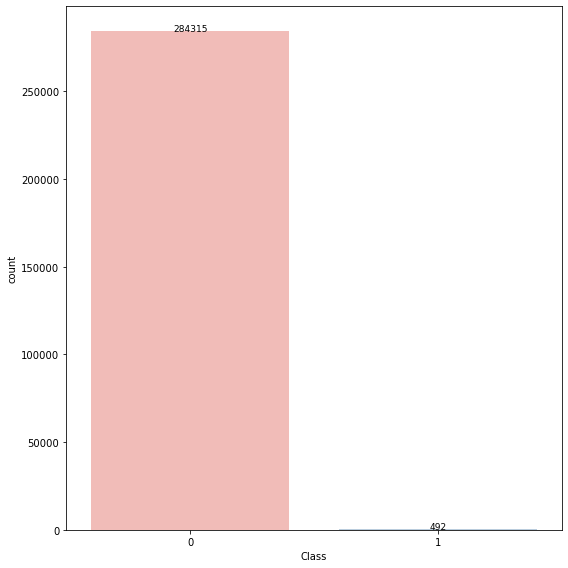

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
plt.rcParams['axes.facecolor'] = 'white'
ax = sns.countplot(x='Class', data=card_df, palette='Pastel1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.tight_layout()

In [28]:
card_df = card_df.sort_values(by='Class')
card_df = card_df.reset_index(drop=True)

In [29]:
X1 = card_df.iloc[len(card_df) - 20000:-1, :-1]
y1 = card_df.iloc[len(card_df) - 20000:-1, -1]

X_train1 = X1[:int(0.8*len(X1))]
X_test1 = X1[int(0.8*len(X1)):]
y_train1 = y1[:int(0.8*len(y1))]
y_test1 = y1[int(0.8*len(y1)):]

print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(15999, 29)
(4000, 29)
(15999,)
(4000,)
264807    0
264808    0
264809    0
264810    0
264811    0
         ..
284801    1
284802    1
284803    1
284804    1
284805    1
Name: Class, Length: 19999, dtype: int64


### 3. One-Class SVM (OCSVM)

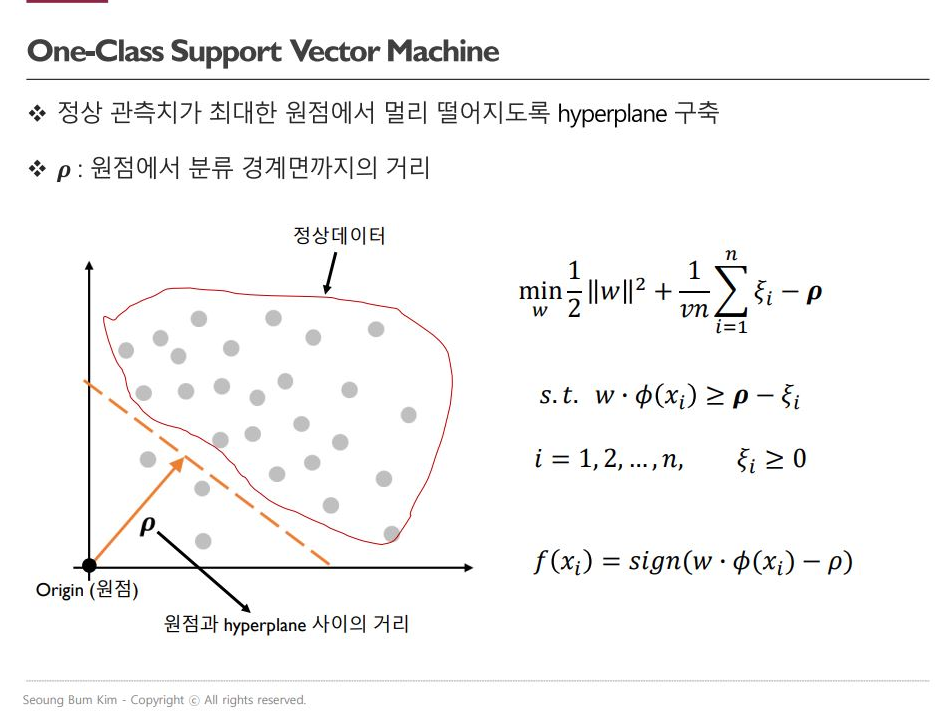

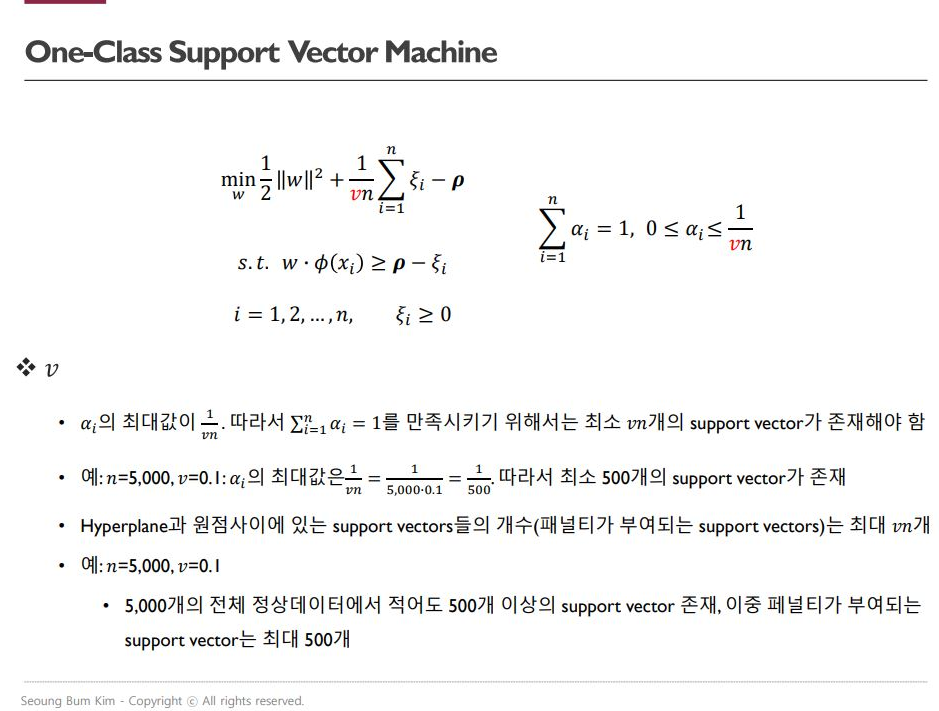

#### 3-1. Classification Data

In [30]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto')
one_class_svm.fit(X_train)

# kernel = ['rbf', 'poly', 'linear', 'sigmoid']
# nu = [0.001, 0.01, 0.05, 0.1, 0.25]

OneClassSVM(gamma='auto', nu=0.01)

acc : 0.905
precision_score : 0.3359073359073359
recall_score : 0.8285714285714286
f1_score : 0.478021978021978
[[1723   18]
 [ 172   87]]


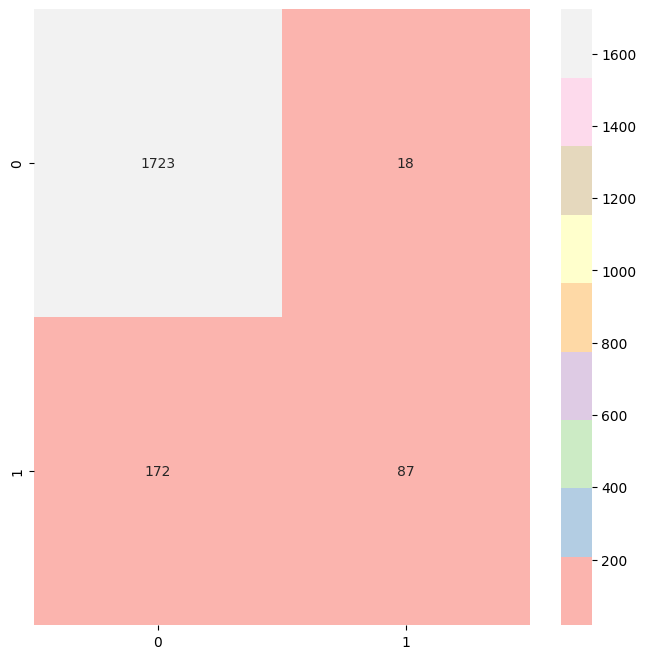

In [31]:
y_pred = one_class_svm.predict(X_test)
y_pred = [1 if i==-1 else 0 for i in y_pred]

performance = return_result(y_pred, y_test)

for k, v in performance.items():
    print(k, ':', v)

print(cf_vis(y_test, y_pred))


Best params: {'kernel': 'rbf', 'nu': 0.01}
acc : 0.905
precision_score : 0.8285714285714286
recall_score : 0.3359073359073359
f1_score : 0.478021978021978


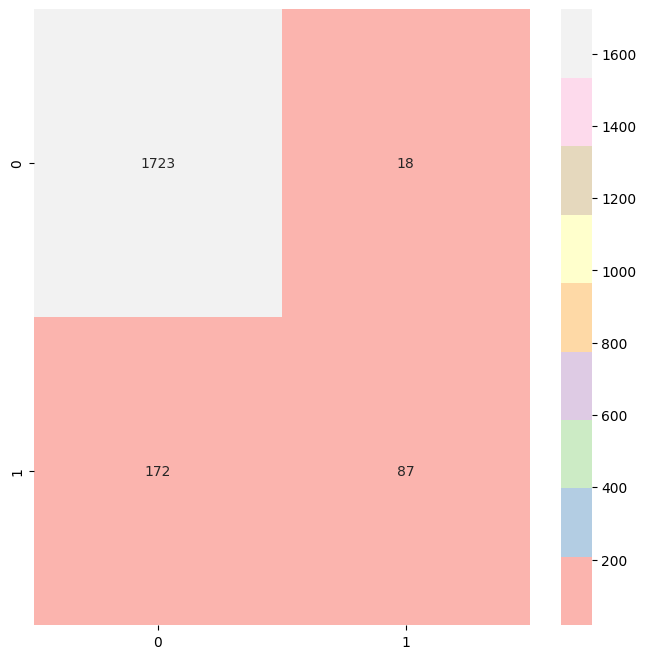

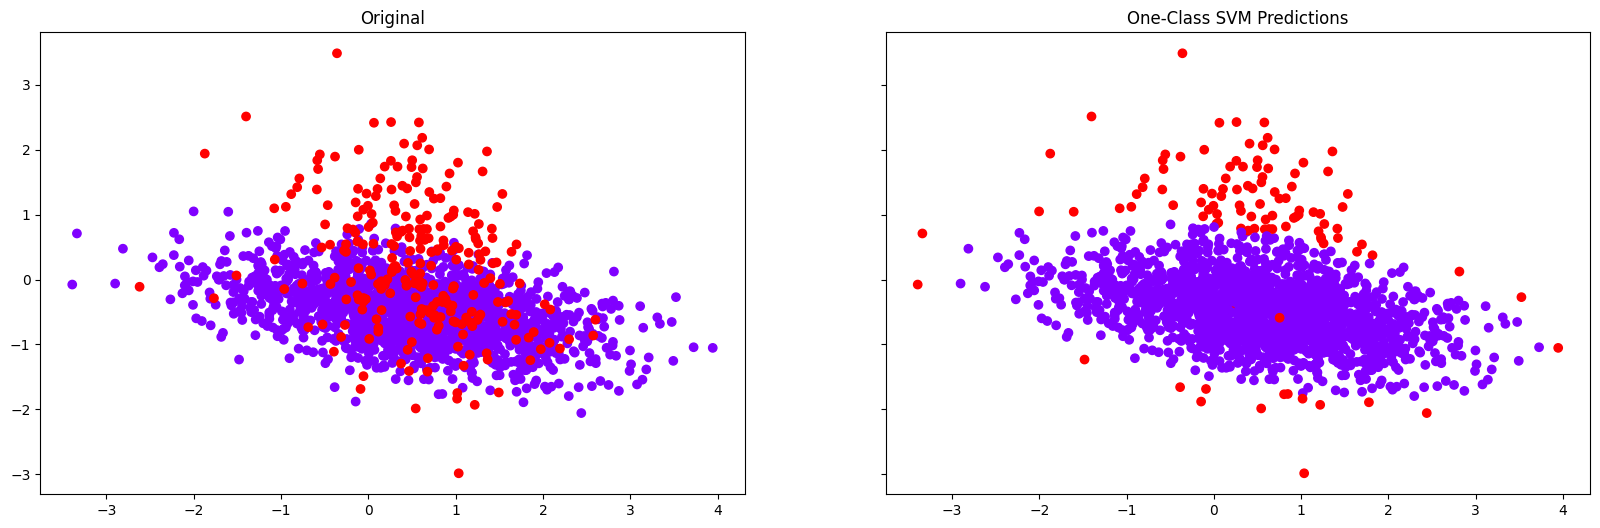

In [32]:
from sklearn.model_selection import GridSearchCV

def OCSVM_GridSearch(X, y):

    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    y_train = y[:int(0.8*len(y))]
    y_test = y[int(0.8*len(y)):]
        
    model = OneClassSVM(gamma='auto')

    param_grid = {'nu': [0.01, 0.05, 0.1, 0.2], 
                        'kernel': ['rbf', 'poly', 'linear']}
        
    grid_search = GridSearchCV(model, param_grid, scoring="f1_weighted", cv=5)

    grid_search.fit(X_train)
        
    best_params = grid_search.best_params_
    print(f"Best params: {best_params}")
        
    ocsvm_clf = OneClassSVM(**best_params, gamma='auto')
    ocsvm_clf.fit(X_train)

    y_pred = ocsvm_clf.predict(X_test)
    y_pred = [1 if i==-1 else 0 for i in y_pred]
    
    performance = return_result(y_test, y_pred)
    
    cf_vis(y_test, y_pred)

    for k, v in performance.items():
        print(k, ':', v)

     # Put the testing dataset and predictions in the same dataframe
    df_test = pd.DataFrame(X_test.iloc[:, :2], columns=['feature1', 'feature2'])
    df_test['y_test'] = y_test
    df_test['one_class_svm_prediction'] = y_pred

    # Visualize the actual and predicted anomalies
    fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(20,6))
    # Ground truth
    ax0.set_title('Original')
    ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
    # One-Class SVM Predictions
    ax1.set_title('One-Class SVM Predictions')
    ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')

OCSVM_GridSearch(X, y)

#### 3.2 CreditCard data

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train1)
X_train_scaled = scaler.transform(X_train1)

scaler.fit(X_test1)
X_test_scaled = scaler.transform(X_test1)

In [34]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.1, kernel = 'rbf', gamma = 'auto')

In [35]:
one_class_svm.fit(X_train_scaled)

OneClassSVM(gamma='auto', nu=0.1)

In [36]:
y_pred = one_class_svm.predict(X_test_scaled)
y_pred = [1 if i==-1 else 0 for i in y_pred]

acc : 0.93075
precision_score : 0.7346491228070176
recall_score : 0.6822810590631364
f1_score : 0.7074973600844774
[[3388  121]
 [ 156  335]]


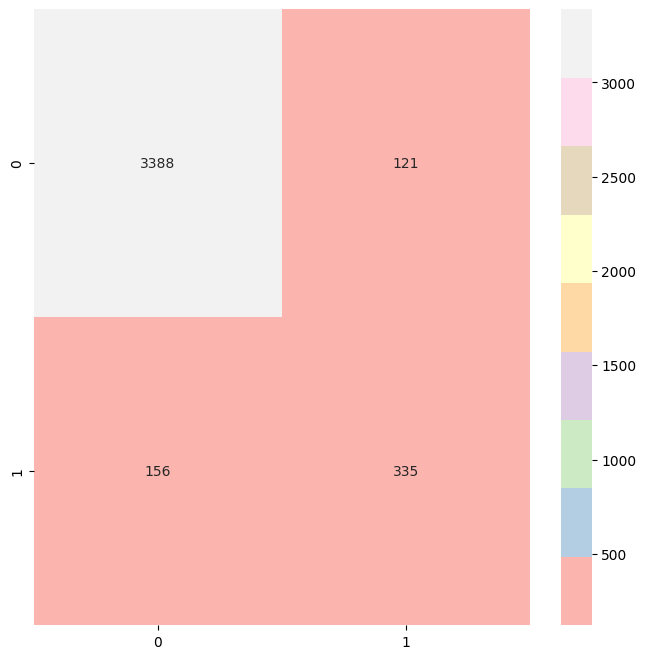

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

performance = return_result(y_test1, y_pred)

for k, v in performance.items():
    print(k, ':', v)
    
print(cf_vis(y_test1, y_pred))

#### 3.3 One-class Support Vector Machine with GridSearchCV

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'kernel': 'rbf', 'nu': 0.001}
acc : 0.9415
precision_score : 0.8463611859838275
recall_score : 0.639511201629328
f1_score : 0.728538283062645


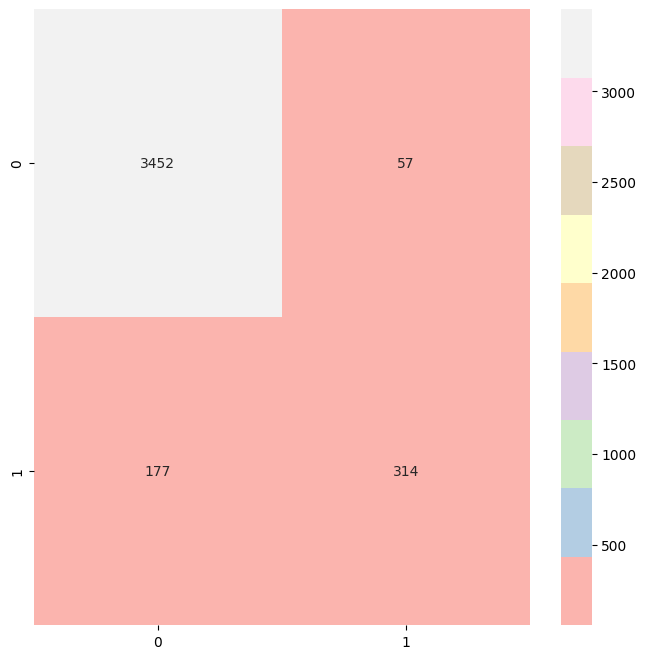

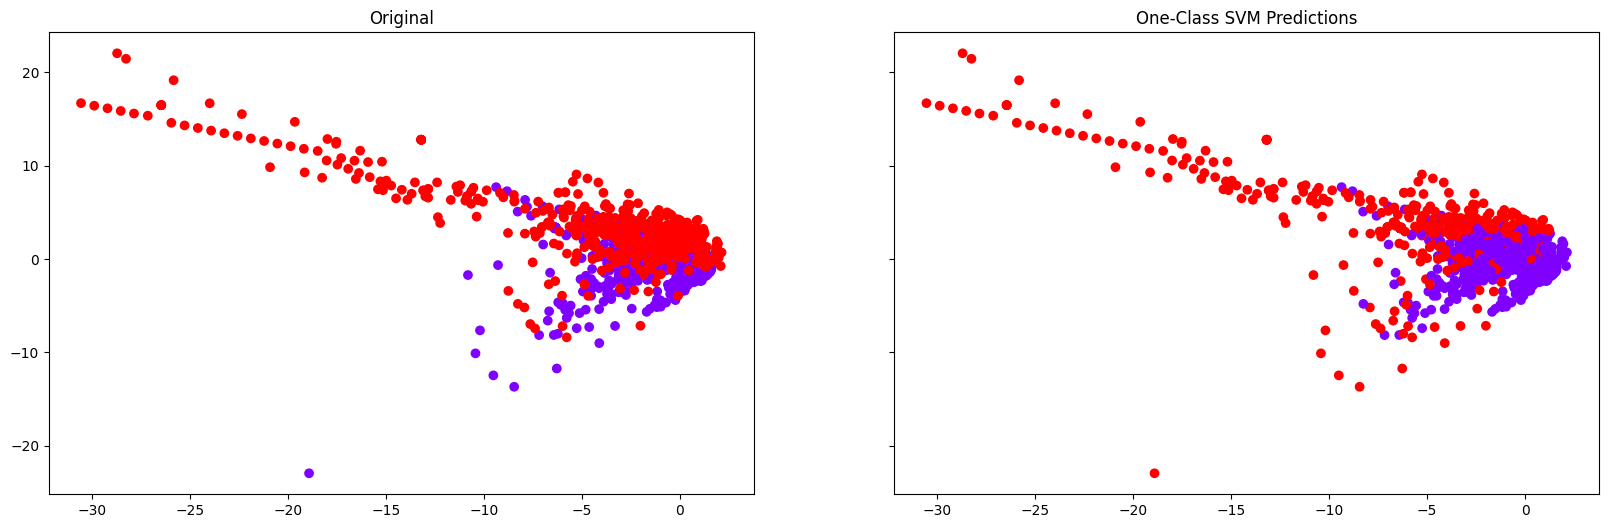

In [38]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('./creditcard.csv')
df = df.drop('Time', axis=1)

def OCSVM_GridSearch(df):
    
    df = df.sort_values(by='Class')
    df = df.reset_index().drop('index', axis=1)
    X = df.iloc[len(df) - 20000:-1, :-1]
    y = df.iloc[len(df) - 20000:-1, -1]

    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    y_train = y[:int(0.8*len(y))]
    y_test = y[int(0.8*len(y)):]
        
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    scaler.fit(X_test)
    X_test_scaled = scaler.transform(X_test)

    model = OneClassSVM(gamma='auto')

    param_grid = {'nu': [0.001, 0.01, 0.05, 0.1, 0.2], 
                        'kernel': ['rbf', 'poly', 'linear']}
        
    grid_search = GridSearchCV(model, param_grid, scoring="f1_weighted", cv=5, verbose=1)

    grid_search.fit(X_train_scaled)
        
    best_params = grid_search.best_params_
    print(f"Best params: {best_params}")
        
    ocsvm_clf = OneClassSVM(**best_params, gamma='auto')
    ocsvm_clf.fit(X_train_scaled)

    y_pred = ocsvm_clf.predict(X_test_scaled)
    y_pred = [1 if i==-1 else 0 for i in y_pred]
    
    performance = return_result(y_test, y_pred)
    
    cf_vis(y_test, y_pred)

    for k, v in performance.items():
        print(k, ':', v)

     # Put the testing dataset and predictions in the same dataframe
    df_test = pd.DataFrame(X_test.iloc[:, :2], columns=['V1', 'V2'])
    df_test['y_test'] = y_test
    df_test['one_class_svm_prediction'] = y_pred

    # Visualize the actual and predicted anomalies
    fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(20,6))
    # Ground truth
    ax0.set_title('Original')
    ax0.scatter(df_test['V1'], df_test['V2'], c=df_test['y_test'], cmap='rainbow')
    # One-Class SVM Predictions
    ax1.set_title('One-Class SVM Predictions')
    ax1.scatter(df_test['V1'], df_test['V2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')

OCSVM_GridSearch(df)

### 4. Support Vector Data Description (SVDD)


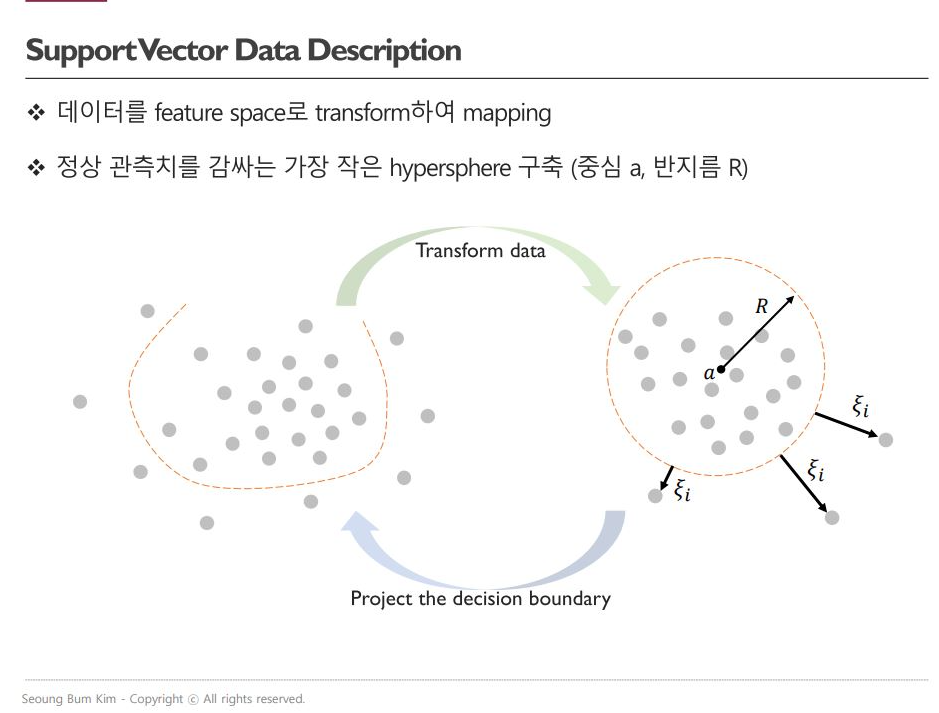

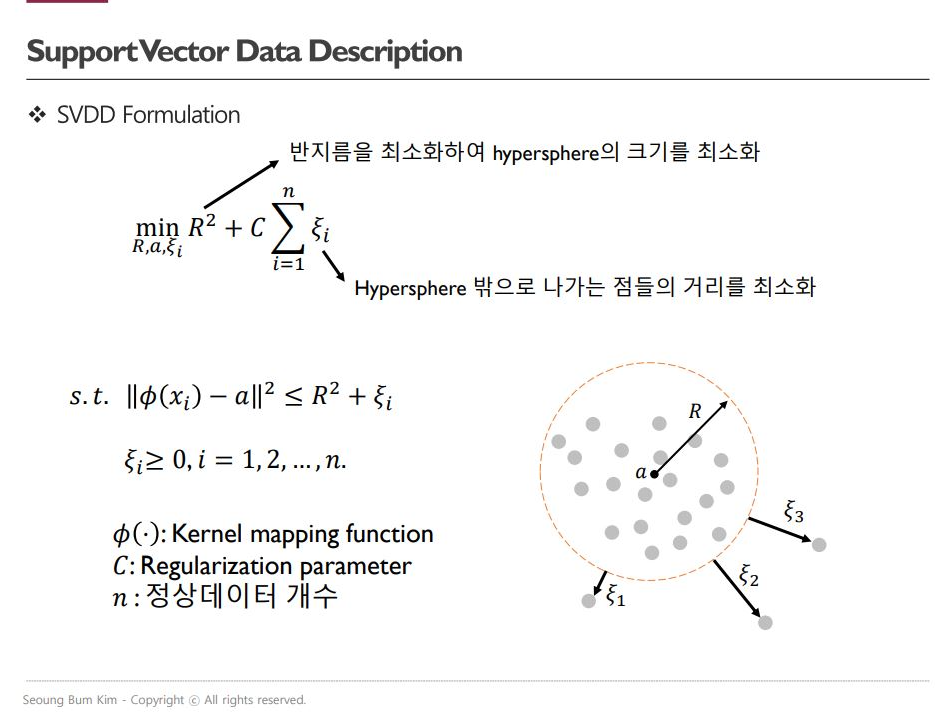

#### 4-1. MakeClassification Dataset

In [43]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.98, 0.02],
                           class_sep=0.5, random_state=2022)

y = [-1 if i == 1 else 1 for i in y]
# Convert the data from numpy array to a pandas dataframe
MC_df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})
# Check the target distribution


MC_df

feature1  feature2  target
0    -0.288017 -0.319407       1
1     0.461567  0.222732       1
2     1.947707 -0.952528       1
3     0.702101 -0.971503       1
4     0.291875 -0.837983       1
...        ...       ...     ...
9995  0.649173 -1.040183       1
9996 -0.485421  0.232143       1
9997  2.315266 -1.152743       1
9998  1.469482  0.211030       1
9999 -0.060250 -0.100417       1

[10000 rows x 3 columns]

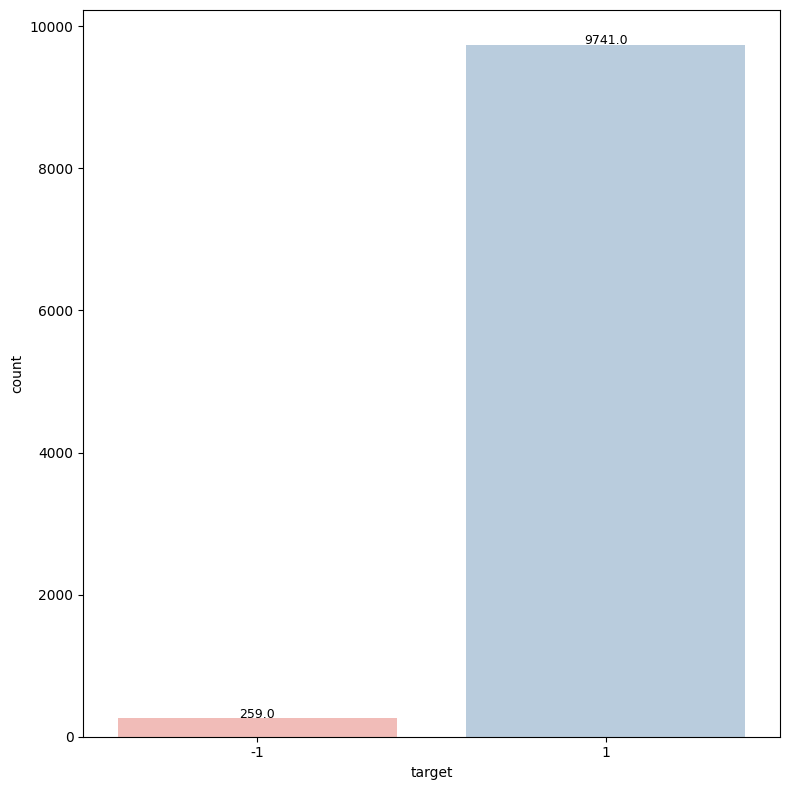

In [44]:
plt.figure(figsize=(8,8))
plt.rcParams['axes.facecolor'] = 'white'
ax = sns.countplot(x='target', data=MC_df, palette='Pastel1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.tight_layout()

In [45]:
MC_df = MC_df.sort_values(by='target', ascending=False)
MC_df = MC_df.reset_index().drop('index', axis=1)

X = MC_df.iloc[:, :-1]
y = MC_df.iloc[:, -1]

# Train:Test = 8:2
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(len(y_train[y_train == 1]))
print(len(y_train[y_train == -1]))
print(len(y_test[y_test == 1]))
print(len(y_test[y_test == -1]))

(8000, 2)
(2000, 2)
(8000,)
(2000,)
8000
0
1741
259


#### 4.2 SVDD Modeling

In [4]:
import time
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels

In [47]:
class BaseSVDD(BaseEstimator, OutlierMixin):
    def __init__(self, 
                 C=0.9,
                 kernel='rbf',
                 degree=3,
                 gamma=None,
                 coef0=1,
                 display='on',
                 n_jobs=None):

        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma       
        self.coef0 = coef0
        self.n_jobs = n_jobs
        self.display = display
        self.X = None
        self.y = None
        self.weight = None
        self.exist_label = True
        self.label_type = None
        self.support_vectors = None
        self.support_vector_indices = None
        self.n_support_vectors = None
        self.n_iterations = None
        self.object_value = None
        self.alpha = None
        self.alpha_tolerance = 1e-6
        self.support_vector_alpha = None
        self.n_support_vectors_ratio = None
        self.radius = None
        self.center = None
        self.offset = None
        self.distance = None
        self.accuracy = None
        self.predicted_y = None
        self.running_time = None
        self.boundary_indices = None
        self.classes_ = None
        

   
    @property 
    def n_samples(self):
        return self.X.shape[0]
    @property 
    def n_features(self):
        return self.X.shape[1]
    @property 
    def n_positive_samples(self):
        return np.sum(self.y == 1)
    @property 
    def n_negative_samples(self):
        return np.sum(self.y == -1)
    
 
    def fit(self, X, y=None, weight=None):

        start_time = time.time()
        # parameter preprocessing
        self.X, self.y, self.y_type, self.exist_y = self._check_X_y(X, y)

        if self.y_type == 'single':
            self.C = [self.C, 1]
    
        if self.y_type == 'hybrid':
            self.C = [self.C, 2/self.n_negative_samples]
            
        if weight is None:
            self.weight = np.ones((self.n_samples, 1), dtype=np.int64)
        else:
            self.weight = weight   
            
        # check 'gamma'
        if self.gamma == 0:
            raise ValueError(
                "The gamma value of 0.0 is invalid. Use 'auto' to set"
                " gamma to a value of 1 / n_features.") 
        if self.gamma is None:
            self.gamma = 'scale'
        if isinstance(self.gamma, str):
            if self.gamma == "scale":
               X_var = X.var()
               self.gamma = 1.0 / (X.shape[1] * X_var) if X_var != 0 else 1.0
            elif self.gamma == "auto":
                self.gamma = 1.0 / X.shape[1]
            else:
               raise ValueError(
                   "When 'gamma' is a string, it should be either 'scale' or 'auto'.")
  
        # get SVDD model
        self.get_model()
        display_ = self.display
        self.display = 'off'
        self.predicted_y_ = self.predict(self.X, self.y)
        self.accuracy = accuracy_score(self.y, self.predicted_y_)
        self.display = display_
        end_time = time.time()
        self.running_time = end_time - start_time

        # display    
        if self.display == 'on':
           self.display_fit() 
        return self
   
    def get_model(self):
        #
        K = self._get_kernel(self.X, self.X)
        self.solve_problem(K)

    def _get_kernel(self, X, Y=None):
        # get kernel matrix
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma, "degree": self.degree, "coef0": self.coef0}

        return pairwise_kernels(
            X, Y, metric=self.kernel, filter_params=True, n_jobs=self.n_jobs, **params)

    def solve_problem(self, K):
        
        solvers.options['show_progress'] = False
        K = np.multiply(self.y * self.y.T, K)
        
        # P
        n = K.shape[0]
        P = K + K.T
        
        # q
        q = -np.multiply(self.y, np.mat(np.diagonal(K)).T)

        # G
        G1 = -np.eye(n)
        G2 = np.eye(n)
        G = np.append(G1, G2, axis=0)
        
        # h
        h1 = np.zeros([n, 1])
        h2 = np.ones([n, 1])
        
        if self.y_type == 'single':
            h2[self.y == 1] = self.C[0] * self.weight[self.y == 1]
        
        if self.y_type == 'hybrid':
            h2[self.y == 1] = self.C[0] * self.weight[self.y == 1]
            h2[self.y == -1] = self.C[1] * self.weight[self.y == -1]

        h = np.append(h1, h2, axis=0)
        h2_ = h2
        
        # A, b
        A = np.ones([n, 1]).T
        b = np.ones([1, 1])

        # 
        P = matrix(P)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        A = matrix(A)
        b = matrix(b)

        #
        sol = solvers.qp(P, q, G, h, A, b)
        
        self.object_value = np.array(sol['dual objective'])
        self.n_iterations = np.array(sol['iterations'])

        if len(np.array(sol['x'])) == 0:
            warnings.warn("No solution for the SVDD model could be found.\n")
            self.alpha = np.zeros((self.n_samples, 1))
            self.alpha[0][0] = 1
        else:
            self.alpha = np.array(sol['x'])     

        self.alpha = self.y * self.alpha
        self.support_vector_indices = np.where(np.abs(self.alpha) > self.alpha_tolerance)[0][:]
        
        # boundary indices  
        tmp_1 = self.alpha[self.support_vector_indices, 0]
        tmp_2 = h2_[self.support_vector_indices, 0]
        tmp_3 = np.where(tmp_1 < tmp_2)[0][:] 
        tmp_4 = np.where(tmp_1 > self.alpha_tolerance)[0][:] 
        self.boundary_indices = self.support_vector_indices[np.array(list(set(tmp_3) & set(tmp_4)))]

        # support vectors
        self.alpha[np.where(np.abs(self.alpha) < self.alpha_tolerance)[0][:]] = 0
        self.support_vectors = self.X[self.support_vector_indices, :]
        self.support_vector_alpha = self.alpha[self.support_vector_indices]
        self.n_support_vectors = self.support_vector_indices.shape[0]
        self.n_support_vectors_ratio = self.n_support_vectors/self.n_samples

        if self.n_support_vectors_ratio > 0.5:
            warnings.warn("The fitted SVDD model may be overfitting.\n")

        # offset, center, radius
        tmp_5 = np.dot(np.ones((self.n_samples, 1)), self.alpha.T)
        tmp_6 = np.multiply(tmp_5, K)
        tmp_ = -2*np.sum(tmp_6, axis=1, keepdims=True)        
        self.offset = np.sum(np.multiply(np.dot(self.alpha, self.alpha.T), K)) 
        self.center = np.dot(self.alpha.T, self.X)
        self.radius = np.sqrt(np.mean(np.diag(K)) + self.offset+np.mean(tmp_[self.boundary_indices, 0]))

    def predict(self, X, y=None):
        
        start_time = time.time()
        results = {}
        results['X'], results['y'], results['y_type'], results['exist_y'] = self._check_X_y(X, y)
        results['n_samples'] = results['X'].shape[0]
        results['distance'] = self.get_distance(X)
        results['predicted_y'] = np.mat(np.ones(results['n_samples'])).T
        index_ = results['distance'] > self.radius
        results['predicted_y'][index_] = -1
        results['n_alarm'] = np.sum(index_==True)  
          
        if results['exist_y'] == True:
            results['accuracy'] = accuracy_score(results['y'], results['predicted_y'])

        end_time = time.time()
        results['running_time'] = end_time - start_time
        # display    
        if self.display == 'on':
            self.display_predict(results)
        return results['predicted_y']
    
    def get_distance(self, X):
        # compute the distance between the samples and the center
        K = self._get_kernel(X, self.X)
        K_ = self._get_kernel(X, X)
        tmp_1 = np.dot(np.ones((X.shape[0], 1), dtype=np.int64), self.alpha.T)
        tmp_2 = np.multiply(tmp_1, K)
        tmp_ = -2*np.sum(tmp_2, axis=1, keepdims=True)  
        distance = np.sqrt(np.mat(np.diag(K_)).T+self.offset+tmp_)
        return distance
    
    def fit_predict(self, X, y=None, weight=None):
        # Perform fit on X and returns labels for X.
        self.fit(X, y, weight)
        return self.predict(X, y)
        
    def decision_function(self, X):

        return self.radius-self.get_distance(X)
    
    def get_params(self, deep=True):

        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                out.update((key + "__" + k, val) for k, val in deep_items)
            out[key] = value
        return out 

    def set_params(self, **params):

        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition("__")
            if key not in valid_params:
                raise ValueError(
                    "Invalid parameter %s for estimator %s. "
                    "Check the list of available parameters "
                    "with `estimator.get_params().keys()`." % (key, self)
                )

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return self
 
    def _check_X_y(self, X, y):

        # check for labels
        if y is None:
            y = np.ones((X.shape[0], 1))
            exist_y = False
        else:
            exist_y = True   

        # check for object type (numpy.ndarray)
        if type(X) is not np.ndarray or type(y) is not np.ndarray:
            raise SyntaxError("The type of X and y must be 'numpy.ndarray'.\n")
        
        # check for data dimensionality
        if len(X.shape) != 2 or len(y.shape) != 2:
            raise SyntaxError("The X and y must be 2D.\n")
          
        # check for data length
        if X.shape[0] != y.shape[0]:
            raise SyntaxError("The length of X and y must the same.\n")   
             
        # check for label values
        tmp_ = np.unique(y)
        if np.all(tmp_ == np.array([1])) or np.all(tmp_ == np.array([-1])):
            y_type = 'single'
           
        elif np.all(tmp_ == np.array([1, -1])) or np.all(tmp_ == np.array([-1, 1])):
            y_type = 'hybrid'        
          
        else:
            errorText = "SVDD is only supported for one-class or binary classification. "\
                        "The label must be 1 for positive samples or -1 for negative samples.\n"
            raise SyntaxError(errorText)
            
        self.classes_ = np.unique(y)

        return X, y, y_type, exist_y

    def display_fit(self):
        # display the fitting results       
        print('\n')
        print('*** Fitting of the SVDD model is completed. ***\n')
        print('running time         = %.4f seconds'   % self.running_time)
        print('kernel function      = %s'             % self.kernel)
        print('iterations           = %d'             % self.n_iterations)
        print('number of samples    = %d'             % self.n_samples)
        print('number of features   = %d'             % self.n_features)
        print('number of SVs        = %d'             % self.n_support_vectors)
        print('ratio of SVs         = %.4f %%'        % (100*self.n_support_vectors_ratio))
        print('accuracy             = %.4f %%'        % (100*self.accuracy))
        print('\n')        
        
    def display_predict(self, results):
        # display test results       
        print('\n')
        print('*** Prediction of the provided data is completed. ***\n')
        print('running time         = %.4f seconds'   % results['running_time'])
        print('number of samples    = %d'             % results['n_samples'])                                                        
        print('number of alarm      = %d'             % results['n_alarm'])  
        if results['exist_y'] == True:
            print('accuracy             = %.4f %%'        % (100*results['accuracy']))
        print('\n')  

    def plot_distance(self, radius, distance):
        n = distance.shape[0]
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        radius = np.ones((n, 1))*radius

        ax.plot(radius, 
                color='r',
                linestyle='-', 
                marker='None',
                linewidth=3, 
                markeredgecolor='k',
                markerfacecolor='w', 
                markersize=6)
        
        ax.plot(distance,
                color='k',
                linestyle=':',
                marker='o',
                linewidth=1,
                markeredgecolor='k',
                markerfacecolor='C4',
                markersize=6)
        
        ax.set_xlabel('Samples')
        ax.set_ylabel('Distance')
        
        ax.legend(["Radius", "Distance"], 
                  ncol=1, loc=0, 
                  edgecolor='black', 
                  markerscale=1, fancybox=True)
        ax.yaxis.grid()
        plt.show()

In [48]:
svdd_model = BaseSVDD(C=1, gamma=0.3, kernel='rbf', display='on')
svdd_model.fit(X_train.to_numpy(), y_train.to_numpy().reshape(-1, 1))



*** Fitting of the SVDD model is completed. ***

running time         = 132.5588 seconds
kernel function      = rbf
iterations           = 16
number of samples    = 8000
number of features   = 2
number of SVs        = 13
ratio of SVs         = 0.1625 %
accuracy             = 99.9125 %




BaseSVDD(C=[1, 1], gamma=0.3)

In [52]:
from sklearn.metrics import classification_report


y_pred = svdd_model.predict(X_test.to_numpy(), y_test.to_numpy().reshape(-1, 1))
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.97      0.25      0.39       259
           1       0.90      1.00      0.95      1741

    accuracy                           0.90      2000
   macro avg       0.93      0.62      0.67      2000
weighted avg       0.91      0.90      0.87      2000



*** Prediction of the provided data is completed. ***

running time         = 0.3433 seconds
number of samples    = 2000
number of alarm      = 66
accuracy             = 90.1500 %




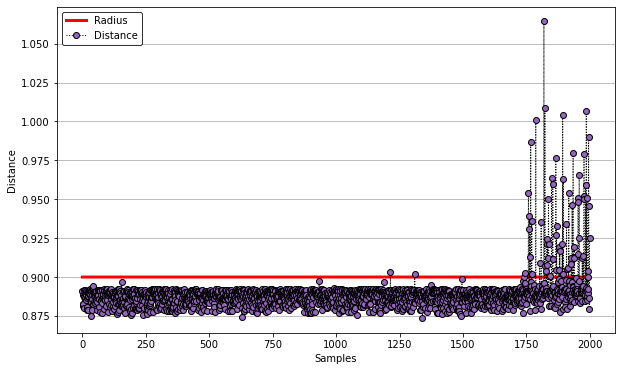

In [42]:
radius = svdd_model.radius
distance = svdd_model.get_distance(X_test)
svdd_model.plot_distance(radius, distance)

### 5. PCA Reconstruction Anomaly Detection

#### 5-1 "2D" PCA Visualization 

In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_2d = PCA(n_components = 2)

df = pd.read_csv('./creditcard.csv')
df = df.drop('Time', axis=1)
df = df.sort_values(by='Class')
df = df.reset_index(drop=True)

X = df.iloc[len(df) - 20000:-1, :-1]
y = df.iloc[len(df) - 20000:-1, -1]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [54]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns[:29])
X_scaled_df.reset_index(drop = True)
X.iloc[:, :] = X_scaled_df

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

result_2d = pca_2d.fit_transform(X)

In [56]:
pc1_2d = result_2d[:,0]
pc2_2d = result_2d[:,1]

pca_df_2d = pd.DataFrame(columns=['pc1', 'pc2', 'label'])
pca_df_2d['pc1'] = pc1_2d
pca_df_2d['pc2'] = pc2_2d
pca_df_2d['label'] = y 


In [57]:
pca_df_2d

pc1       pc2  label
0      -0.009715 -0.497002      0
1      -0.187918 -0.474876      0
2      -0.132598  5.326266      0
3      -0.535077 -0.700138      0
4      -0.339582 -0.591101      0
...          ...       ...    ...
19994   9.599244 -0.572127      1
19995  27.894096 -0.532752      1
19996   6.821792  0.479261      1
19997  28.268415  0.339384      1
19998   6.244115 -2.158530      1

[19999 rows x 3 columns]

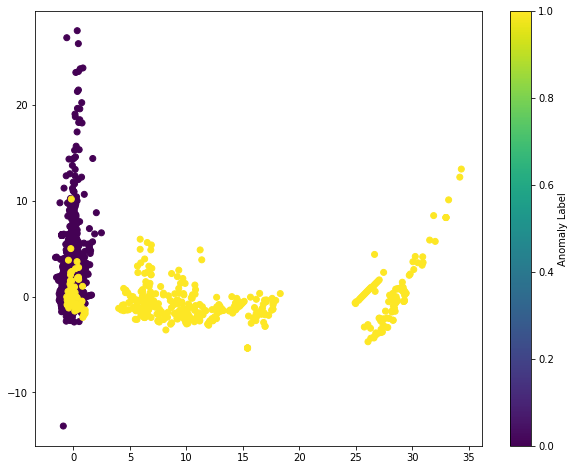

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 8))
plt.scatter(pca_df_2d['pc1'], pca_df_2d['pc2'], c=pca_df_2d['label'])
plt.colorbar(label='Anomaly Label')

#### 5-2 "3D" PCA Visualization 

In [59]:
pca_3d = PCA(n_components=3)

df = pd.read_csv('./creditcard.csv')
df = df.drop('Time', axis=1)
df = df.sort_values(by='Class')
df = df.reset_index().drop('index', axis=1)

X = df.iloc[len(df) - 20000:-1, :-1]
y = df.iloc[len(df) - 20000:-1, -1]

In [60]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y = y.reset_index(drop=True)

result_3d = pca_3d.fit_transform(X)

In [62]:
pc1_3d = result_3d[:, 0]
pc2_3d = result_3d[:, 1]
pc3_3d = result_3d[:, 2]

pca_df3 = pd.DataFrame(columns=['pc1', 'pc2', 'pc3', 'label'])

pca_df3['pc1'] = pc1_3d
pca_df3['pc2'] = pc2_3d
pca_df3['pc3'] = pc3_3d
pca_df3['label'] = y 

In [63]:
import plotly.express as px
fig = px.scatter_3d(pca_df3, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

### 5-3 Anomaly Detection with PCA Reconstruction 

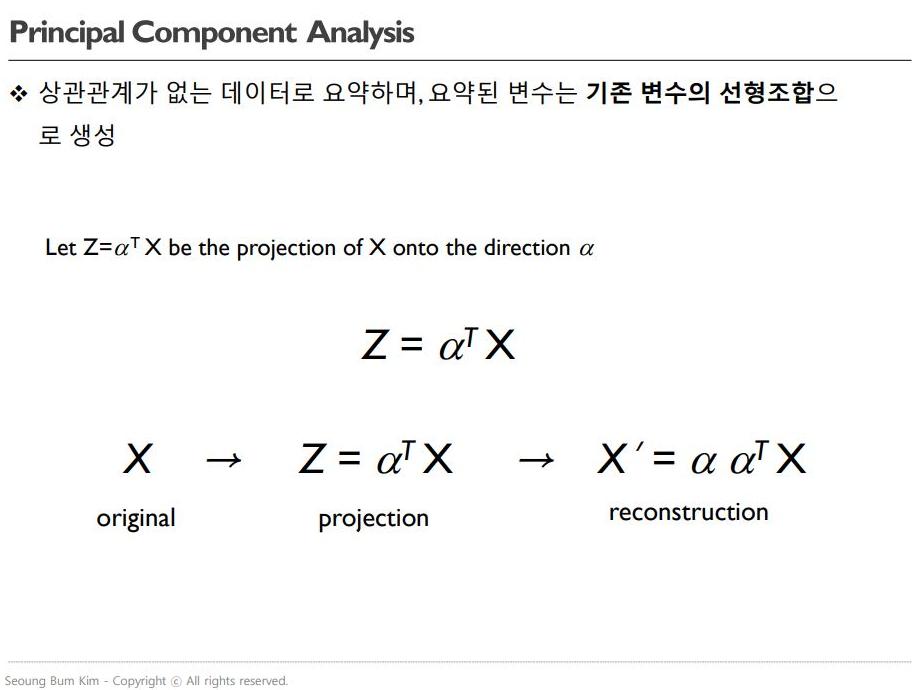

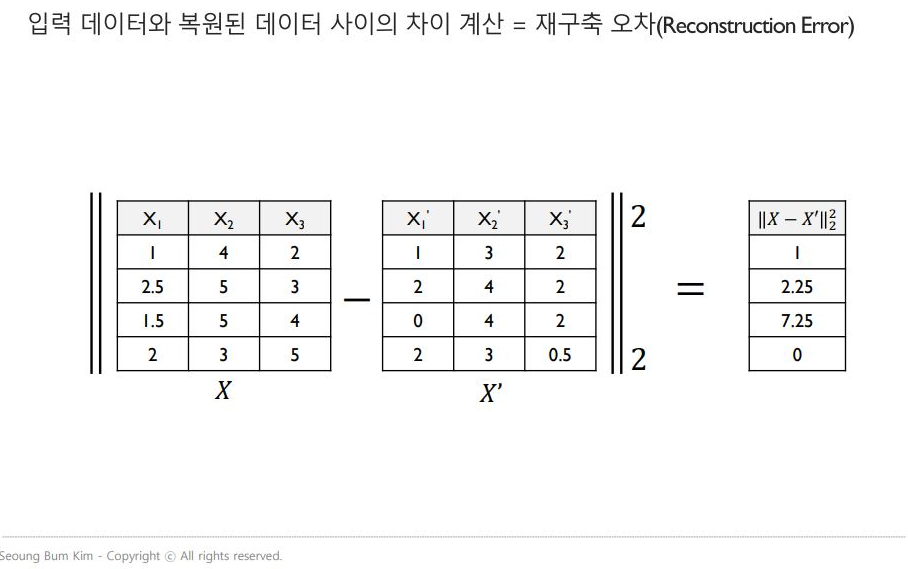

In [64]:
# 2D에 대한 Reconstruction 진행

proj_2d = pca_2d.inverse_transform(result_2d)
proj_2d_df = pd.DataFrame(proj_2d, columns = df.columns[:29])

proj_2d_df

V1        V2        V3        V4        V5        V6        V7  \
0      0.148342  0.176303  0.048061 -0.029960  0.107204 -0.062815 -0.029211   
1      0.178978  0.137280  0.102993 -0.067203  0.141079 -0.045049  0.024584   
2     -1.540402 -1.930714 -0.439438  0.269961 -1.097671  0.693015  0.382613   
3      0.317666  0.157374  0.234281 -0.154800  0.263822 -0.044797  0.112069   
4      0.244811  0.152439  0.161960 -0.106470  0.198469 -0.047220  0.061654   
...         ...       ...       ...       ...       ...       ...       ...   
19994 -1.832697  1.880081 -3.015040  2.040882 -1.955778 -0.877668 -2.857810   
19995 -5.658171  5.058638 -8.863492  5.993860 -5.922141 -2.405742 -8.231516   
19996 -1.563216  1.018835 -2.222798  1.500033 -1.577225 -0.510311 -1.973775   
19997 -5.992960  4.811610 -9.061972  6.123587 -6.187557 -2.325454 -8.285246   
19998 -0.666227  1.862735 -1.799632  1.227407 -0.894426 -0.799608 -1.974203   

             V8        V9       V10  ...       V20       V21       V22  \
0      0.039333 -0.034128  0.010596  ... -0.179269  0.032835 -0.029903   
1      0.029956  0.001419  0.063506  ... -0.178949  0.025486 -0.033904   
2     -0.431627  0.410836 -0.042813  ...  1.911037 -0.359686  0.313401   
3      0.033152  0.051241  0.170734  ... -0.274899  0.029072 -0.057689   
4      0.032777  0.021895  0.110626  ... -0.227278  0.028241 -0.045356   
...         ...       ...       ...  ...       ...       ...       ...   
19994  0.455534 -1.869954 -2.859694  ...  0.205762  0.354527  0.252441   
19995  1.233368 -5.352047 -8.327368  ...  1.004479  0.954840  0.800874   
19996  0.252884 -1.264772 -2.045979  ...  0.465011  0.192853  0.232181   
19997  1.179598 -5.360214 -8.452724  ...  1.334381  0.908996  0.864012   
19998  0.439180 -1.345686 -1.832525  ... -0.509004  0.349782  0.057769   

            V23       V24       V25       V26       V27       V28    Amount  
0      0.047343 -0.035823  0.053396 -0.008560  0.075118  0.134104 -0.320359  
1      0.043957 -0.033405  0.055345 -0.008129  0.071855  0.128578 -0.307536  
2     -0.509060  0.385001 -0.566495  0.091805 -0.804915 -1.436580  3.431305  
3      0.062963 -0.048061  0.087849 -0.011913  0.106059  0.190213 -0.455499  
4      0.053960 -0.041094  0.071451 -0.010089  0.089490  0.160311 -0.383657  
...         ...       ...       ...       ...       ...       ...       ...  
19994  0.123260 -0.085541 -0.171315 -0.012550  0.082076  0.130472 -0.291308  
19995  0.250401 -0.167037 -0.618662 -0.017004  0.067756  0.074347 -0.118448  
19996  0.003088  0.003140 -0.216499  0.006344 -0.075553 -0.146261  0.363842  
19997  0.169879 -0.105822 -0.721014 -0.002083 -0.064224 -0.161867  0.446595  
19998  0.250594 -0.184563  0.079636 -0.038942  0.323369  0.566794 -1.340671  

[19999 rows x 29 columns]

In [65]:
diff = proj_2d_df - X

In [66]:
diff

V1        V2        V3        V4        V5        V6        V7  \
0      0.119553  0.348648 -0.584580  1.524754  0.518597  0.102348  0.025448   
1     -0.479006  0.121259 -0.048280 -0.709900  0.116202 -0.096560 -0.030946   
2     -0.739010 -1.750215  1.187964  0.034629  0.792939 -4.564708 -3.090500   
3      0.435746  0.323825 -0.494645  1.871387  0.463193 -0.021817  0.218308   
4     -0.499793  0.155940  0.393255 -0.014898  0.240675  1.017715 -0.244179   
...         ...       ...       ...       ...       ...       ...       ...   
19994 -0.446005  1.877737  0.370641 -0.071842 -2.495307  0.361720 -2.240610   
19995 -1.686546  1.502496 -2.288423  1.134389  0.438776 -0.758394 -2.693190   
19996 -1.027795  0.452442 -1.148382 -0.220116 -0.107461 -0.221004 -1.264043   
19997  0.914113  0.786810  0.869259 -1.167549 -1.996523 -0.672283  0.065231   
19998 -1.368053  0.246623  1.592916 -2.314073 -2.179513  0.647969 -1.558514   

             V8        V9       V10  ...       V20       V21       V22  \
0      0.066961  2.185368 -0.820978  ...  0.288496  0.302395  0.498489   
1     -0.010503 -0.320756  0.033395  ...  0.079836  0.186408  0.233193   
2     -0.581173  1.587031  1.127603  ...  1.424101 -0.213073  0.921052   
3      0.002101  2.072083 -0.534556  ... -0.127600  0.055203 -0.661200   
4      0.259279 -0.277332  0.108818  ...  0.012768  0.501624  1.911790   
...         ...       ...       ...  ...       ...       ...       ...   
19994  0.084031  0.748263  0.263326  ... -0.074094 -0.626238 -1.739589   
19995 -2.270012  0.992272  0.152715  ...  1.951526 -1.040498  2.457637   
19996 -0.234764 -0.148741  0.506802  ... -1.142579 -0.642057 -0.633062   
19997  1.704415  0.798845  0.643214  ... -0.087058  3.595887 -0.358447   
19998  0.281510  1.069876  0.587865  ... -0.772512  0.203369  1.281398   

            V23       V24       V25       V26       V27       V28    Amount  
0     -0.163664 -0.297446  1.383353  1.183167  0.122631 -0.013679 -0.051471  
1     -0.124733 -0.379977 -0.511722  1.209120 -0.039584  0.069807  0.025512  
2     -1.721754 -1.123509 -1.798575  0.652974 -1.742273 -0.416129 -2.339693  
3      0.611981  0.792044 -0.811652  0.336036 -0.567142 -0.162493 -0.131183  
4     -0.322108 -0.650031  0.235051 -1.287350  0.347145  0.147386 -0.089046  
...         ...       ...       ...       ...       ...       ...       ...  
19994 -2.701972  0.129888 -2.597295  0.038893 -2.192145  0.114765 -1.285347  
19995  0.067980 -0.901992 -1.358265  0.667032 -1.081244  1.461757 -1.707697  
19996 -0.903419 -0.517391 -0.012616 -1.699555 -0.977154 -0.972230 -0.622065  
19997  0.626731  1.551764 -2.646105 -1.688713 -5.048070  3.466712  0.817994  
19998  0.287559 -0.153449 -0.395835 -0.124386 -0.715481 -0.433233 -0.964992  

[19999 rows x 29 columns]

In [67]:
diff = diff.pow(2)
diff['y_true'] = y

diff

V1        V2        V3        V4        V5         V6        V7  \
0      0.014293  0.121555  0.341733  2.324873  0.268943   0.010475  0.000648   
1      0.229447  0.014704  0.002331  0.503958  0.013503   0.009324  0.000958   
2      0.546136  3.063253  1.411259  0.001199  0.628752  20.836558  9.551190   
3      0.189875  0.104862  0.244674  3.502089  0.214548   0.000476  0.047658   
4      0.249793  0.024317  0.154649  0.000222  0.057924   1.035744  0.059624   
...         ...       ...       ...       ...       ...        ...       ...   
19994  0.198920  3.525896  0.137375  0.005161  6.226556   0.130842  5.020335   
19995  2.844438  2.257495  5.236881  1.286839  0.192524   0.575161  7.253274   
19996  1.056362  0.204704  1.318781  0.048451  0.011548   0.048843  1.597805   
19997  0.835603  0.619070  0.755611  1.363170  3.986105   0.451965  0.004255   
19998  1.871570  0.060823  2.537382  5.354933  4.750275   0.419864  2.428965   

             V8        V9       V10  ...        V21       V22       V23  \
0      0.004484  4.775833  0.674005  ...   0.091443  0.248492  0.026786   
1      0.000110  0.102884  0.001115  ...   0.034748  0.054379  0.015558   
2      0.337762  2.518668  1.271488  ...   0.045400  0.848336  2.964437   
3      0.000004  4.293530  0.285750  ...   0.003047  0.437185  0.374521   
4      0.067225  0.076913  0.011841  ...   0.251626  3.654942  0.103754   
...         ...       ...       ...  ...        ...       ...       ...   
19994  0.007061  0.559897  0.069340  ...   0.392174  3.026169  7.300655   
19995  5.152954  0.984604  0.023322  ...   1.082637  6.039978  0.004621   
19996  0.055114  0.022124  0.256848  ...   0.412237  0.400768  0.816166   
19997  2.905029  0.638153  0.413724  ...  12.930405  0.128484  0.392792   
19998  0.079248  1.144635  0.345586  ...   0.041359  1.641980  0.082690   

            V24       V25       V26        V27        V28    Amount  y_true  
0      0.088474  1.913665  1.399883   0.015038   0.000187  0.002649       0  
1      0.144382  0.261859  1.461971   0.001567   0.004873  0.000651       0  
2      1.262273  3.234871  0.426375   3.035517   0.173163  5.474162       0  
3      0.627333  0.658778  0.112920   0.321650   0.026404  0.017209       0  
4      0.422540  0.055249  1.657271   0.120510   0.021723  0.007929       0  
...         ...       ...       ...        ...        ...       ...     ...  
19994  0.016871  6.745942  0.001513   4.805501   0.013171  1.652116       1  
19995  0.813589  1.844883  0.444931   1.169088   2.136734  2.916230       1  
19996  0.267694  0.000159  2.888487   0.954830   0.945231  0.386965       1  
19997  2.407971  7.001870  2.851751  25.483008  12.018094  0.669114       1  
19998  0.023546  0.156685  0.015472   0.511914   0.187691  0.931209       1  

[19999 rows x 30 columns]

In [68]:
sum_list = list((diff.sum(axis=1)).values)

In [70]:
y_pred_list = []

for item in sum_list:
    if item > np.percentile(sum_list, 95):
        y_pred_list.append(1)
    else:
        y_pred_list.append(0)

diff['y_pred'] = y_pred_list

acc : 0.9289464473223661
precision_score : 0.209375
recall_score : 0.6822810590631364
f1_score : 0.3204208512673362


array([[18243,  1265],
       [  156,   335]], dtype=int64)

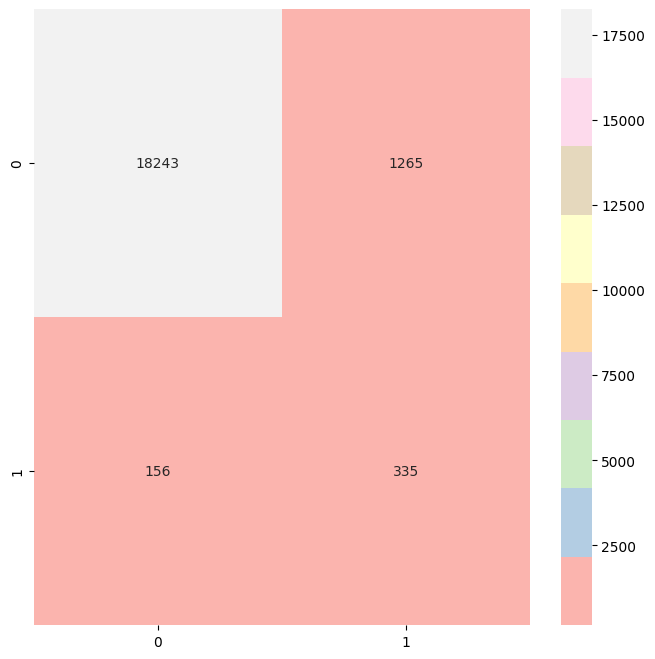

In [202]:
performance = return_result(y, y_pred_list)

for k, v in performance.items():
    print(k, ':', v)

cf_vis(y, y_pred_list)

acc : 0.9527476373818691
precision_score : 0.273
recall_score : 0.5560081466395111
f1_score : 0.36619718309859156


array([[18781,   727],
       [  218,   273]], dtype=int64)

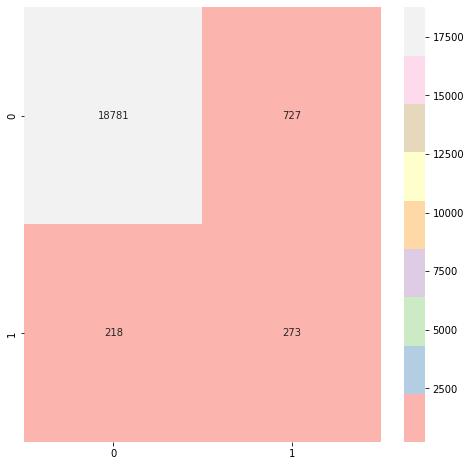

In [73]:
performance = return_result(y, y_pred_list)

for k, v in performance.items():
    print(k, ':', v)

cf_vis(y, y_pred_list)

# EOD